# 1- Data Acquisition

We are going to use a dataset that is already collected.

In [1]:
pip install wordcloud tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import json
from glob import glob
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [5]:
def jsonl_to_dataframe(file_path):
    """Fonction pour lire un fichier JSONL et retourner un DataFrame pandas"""
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line))
    return pd.DataFrame(data)

def merge_jsonl_to_dataframe(file_pattern):
    """Fonction pour fusionner plusieurs fichiers JSONL en un seul DataFrame pandas"""
    # Récupérer la liste des fichiers correspondant au modèle fourni
    files = glob(file_pattern)
    
    
    # Lire chaque fichier JSONL et stocker les DataFrames individuels dans une liste
    dfs = [jsonl_to_dataframe(file) for file in files]
    # Concaténer les DataFrames
    merged_df = pd.concat(dfs, ignore_index=True)
    
    return merged_df

# Modèle de chemin vers les fichiers JSONL à fusionner
file_pattern = "data/*.jsonl"

# Appel de la fonction pour fusionner les fichiers JSONL en un DataFrame
df = merge_jsonl_to_dataframe(file_pattern)

# Afficher le DataFrame fusionné
len(df)

48644

In [15]:
# Creating the answers_df
human_df = pd.DataFrame({'questions': df['question'], 'answers': df['human_answers'], 'is_human': 1 })
gpt_df = pd.DataFrame({'questions': df['question'], 'answers': df['chatgpt_answers'], 'is_human': 0})
answers_df = pd.concat([human_df, gpt_df], axis=0, ignore_index=True)

csv = pd.read_csv("data/hack_train.csv")
csvFull = csv.rename(columns={'text': 'answers', "label" : "is_human"})
csv = csvFull.drop(columns="src")
answers_df = pd.concat([answers_df, csv])
# Checking the len
answers_df = answers_df.explode('answers', ignore_index=True)
answers_df = answers_df.dropna(subset=['answers'], ignore_index=True)

answers_df

,questions,answers,is_human
0,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",1
1,"Why is every book I hear about a "" NY Times # ...","If you 're hearing about it , it 's because it...",1
2,"Why is every book I hear about a "" NY Times # ...","One reason is lots of catagories . However , h...",1
3,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,1
4,"If salt is so bad for cars , why do we use it ...","In Minnesota and North Dakota , they tend to u...",1
...,...,...,...
227712,NaN,We consider the recovery of a source term f (x...,1
227713,NaN,"Self-supervised learning (SlfSL), aiming at le...",1
227714,NaN,Recurrent neural networks (RNNs) have achieved...,1
227715,NaN,Deep reinforcement learning (DRL) is a booming...,1


#  Setup the dataFrame for the predictive models

In [16]:
answers_df.head()

,questions,answers,is_human
0,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",1
1,"Why is every book I hear about a "" NY Times # ...","If you 're hearing about it , it 's because it...",1
2,"Why is every book I hear about a "" NY Times # ...","One reason is lots of catagories . However , h...",1
3,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,1
4,"If salt is so bad for cars , why do we use it ...","In Minnesota and North Dakota , they tend to u...",1


# 2. Exploring the data

Whenever we start working with a new dataset, and before we move on to making design decisions and creating a model, we have to get to know our data. Let’s answer some questions regarding our dataset:

**What does human_answers or chatgpt_answers looks like?**

In [17]:
#Human

human_answers_df = answers_df[answers_df['is_human'] == 1]
first_human_answer = human_answers_df.iloc[0]['answers']
print(first_human_answer)


Basically there are many categories of " Best Seller " . Replace " Best Seller " by something like " Oscars " and every " best seller " book is basically an " oscar - winning " book . May not have won the " Best film " , but even if you won the best director or best script , you 're still an " oscar - winning " film . Same thing for best sellers . Also , IIRC the rankings change every week or something like that . Some you might not be best seller one week , but you may be the next week . I guess even if you do n't stay there for long , you still achieved the status . Hence , # 1 best seller .


In [18]:
#Chatgpt

chatgpt_answers_df = answers_df[answers_df['is_human'] == 0]
first_chatgpt_answer = chatgpt_answers_df.iloc[0]['answers']
print(first_chatgpt_answer)

There are many different best seller lists that are published by various organizations, and the New York Times is just one of them. The New York Times best seller list is a weekly list that ranks the best-selling books in the United States based on sales data from a number of different retailers. The list is published in the New York Times newspaper and is widely considered to be one of the most influential best seller lists in the book industry. 
It's important to note that the New York Times best seller list is not the only best seller list out there, and there are many other lists that rank the top-selling books in different categories or in different countries. So it's possible that a book could be a best seller on one list but not on another. 
Additionally, the term "best seller" is often used more broadly to refer to any book that is selling well, regardless of whether it is on a specific best seller list or not. So it's possible that you may hear about a book being a "best selle

**How long are the responses? from humans? from chatgpt?**

Mean responses length:  777.6991627409434
Min overview length:  5
Max overview length:  63723


/tmp/ipykernel_211603/4104485100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_answers_df['responses_length'] = human_answers_df.answers.apply(len)


<Axes: ylabel='Frequency'>

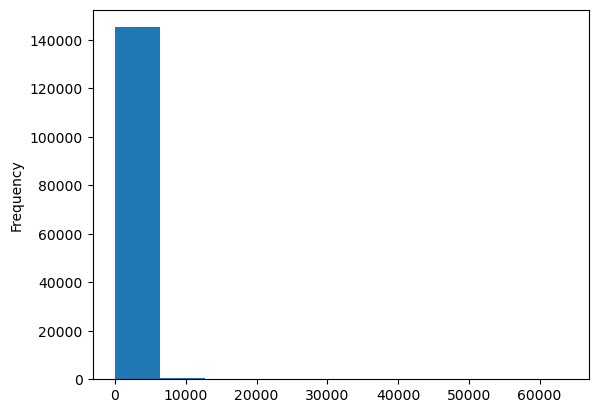

In [19]:
#Human 

human_answers_df['responses_length'] = human_answers_df.answers.apply(len)
print("Mean responses length: ", human_answers_df['responses_length'].mean())
print("Min overview length: ", human_answers_df['responses_length'].min())
print("Max overview length: ", human_answers_df['responses_length'].max())
human_answers_df.responses_length.plot.hist()

Mean responses length:  1105.81361438132
Min overview length:  0
Max overview length:  8033


/tmp/ipykernel_211603/2606865523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chatgpt_answers_df['responses_length'] = chatgpt_answers_df.answers.apply(len)


<Axes: ylabel='Frequency'>

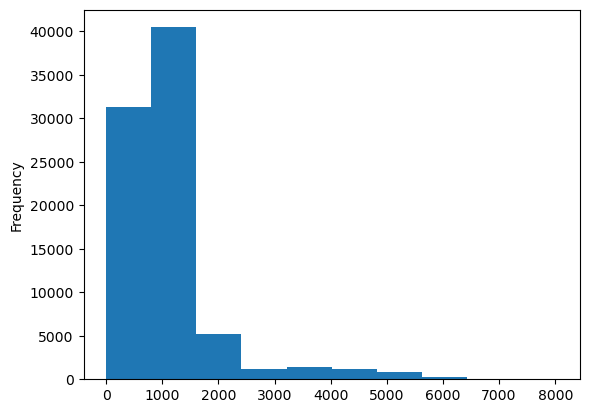

In [20]:
#Chatgpt

chatgpt_answers_df['responses_length'] = chatgpt_answers_df.answers.apply(len)
print("Mean responses length: ", chatgpt_answers_df['responses_length'].mean())
print("Min overview length: ", chatgpt_answers_df['responses_length'].min())
print("Max overview length: ", chatgpt_answers_df['responses_length'].max())
chatgpt_answers_df.responses_length.plot.hist()

**A word cloud to see what are the most common words in the responses**

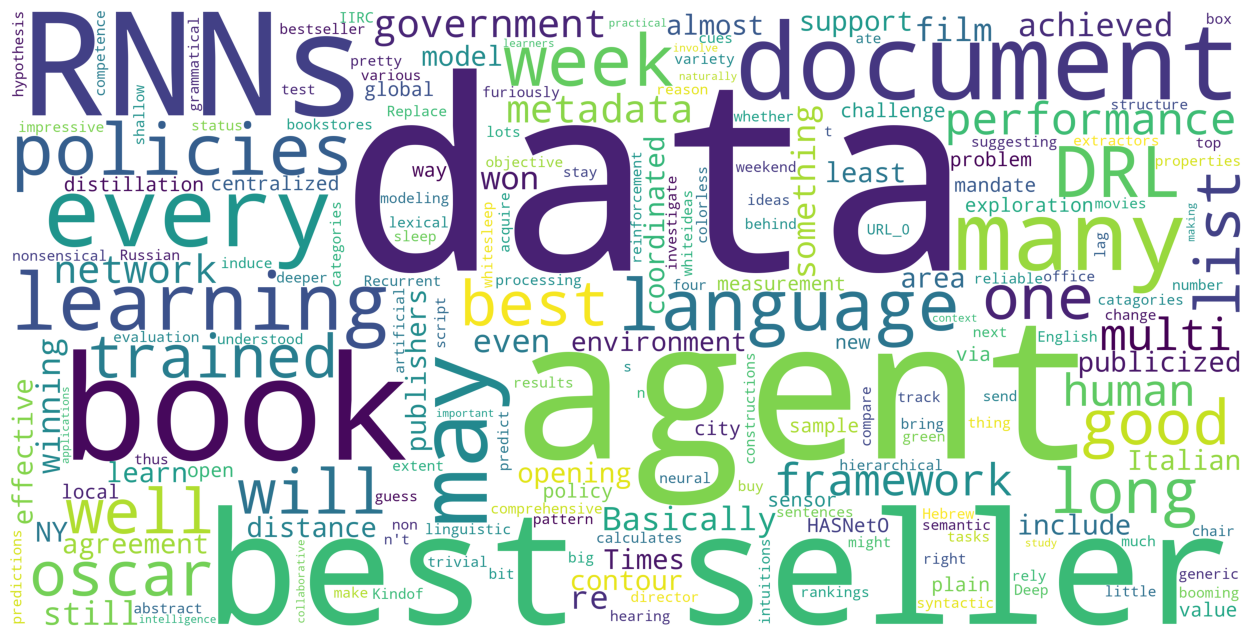

In [21]:
#Human

stopwords = set(STOPWORDS)
humans_words_text = human_answers_df['answers'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(humans_words_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


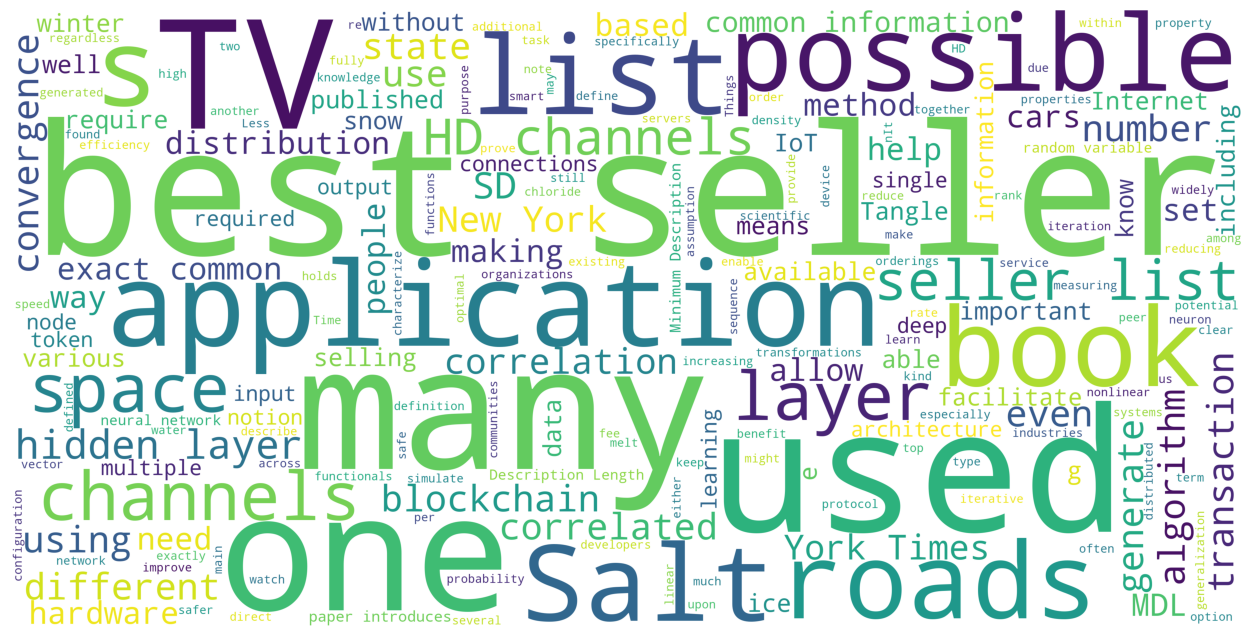

In [22]:
#Chatgpt

stopwords = set(STOPWORDS)
chatgpt_words_text = chatgpt_answers_df['answers'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(chatgpt_words_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [23]:
X = answers_df['answers']
y = answers_df['is_human']

#Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

#Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

max_len = 100  # Choisissez la longueur maximale souhaitée
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)


**Construction du Modèle de Réseau de Neurones**

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 64, input_length=max_len),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [40]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Architecture du modèle :")
model.summary()

Architecture du modèle :


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training

In [41]:
# Entraînement du modèle
print("\nTraining start...")
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_val_pad, y_val))


Training start...
Epoch 1/10
5693/5693 ━━━━━━━━━━━━━━━━━━━━ 111s 19ms/step - accuracy: 0.8644 - loss: 0.4218 - val_accuracy: 0.9224 - val_loss: 0.2266
Epoch 2/10
5693/5693 ━━━━━━━━━━━━━━━━━━━━ 112s 20ms/step - accuracy: 0.9509 - loss: 0.1722 - val_accuracy: 0.9306 - val_loss: 0.2204
Epoch 3/10
5693/5693 ━━━━━━━━━━━━━━━━━━━━ 97s 17ms/step - accuracy: 0.9816 - loss: 0.0984 - val_accuracy: 0.9358 - val_loss: 0.2278
Epoch 4/10
5693/5693 ━━━━━━━━━━━━━━━━━━━━ 107s 19ms/step - accuracy: 0.9925 - loss: 0.0618 - val_accuracy: 0.9349 - val_loss: 0.2449
Epoch 5/10
5693/5693 ━━━━━━━━━━━━━━━━━━━━ 104s 18ms/step - accuracy: 0.9954 - loss: 0.0480 - val_accuracy: 0.9360 - val_loss: 0.2537
Epoch 6/10
5693/5693 ━━━━━━━━━━━━━━━━━━━━ 116s 20ms/step - accuracy: 0.9966 - loss: 0.0414 - val_accuracy: 0.9323 - val_loss: 0.2764
Epoch 7/10
5693/5693 ━━━━━━━━━━━━━━━━━━━━ 118s 21ms/step - accuracy: 0.9970 - loss: 0.0387 - val_accuracy: 0.9329 - val_loss: 0.2883
Epoch 8/10
5693/5693 ━━━━━━━━━━━━━━━━━━━━ 113s 20ms

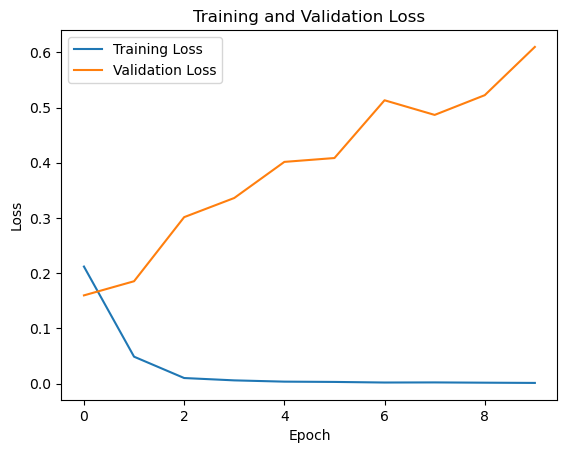

In [28]:
# Affichage de l'historique de la perte
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

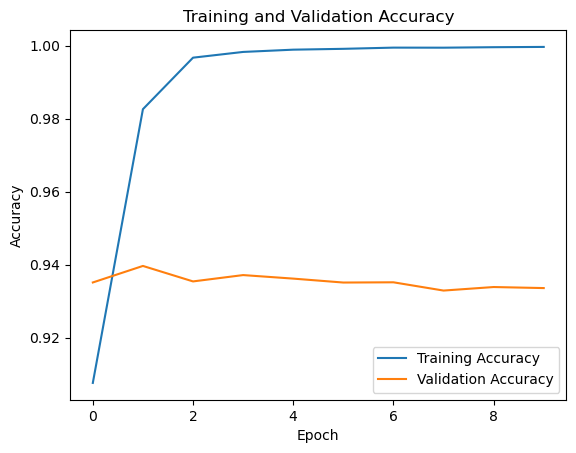

In [29]:
# Affichage de l'historique de la précision
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [30]:
# Supposons que X_test contient vos données de test
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [31]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Évaluation du modèle sur les données de test
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1424/1424 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9360 - loss: 0.5878
Test Loss: 0.6098109483718872
Test Accuracy: 0.9336026906967163


In [32]:
predictions = model.predict(X_test_pad)
predicted_classes = (predictions > 0.5).astype(int)

1424/1424 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Text(0.5, 1.0, 'Matrice de confusion')

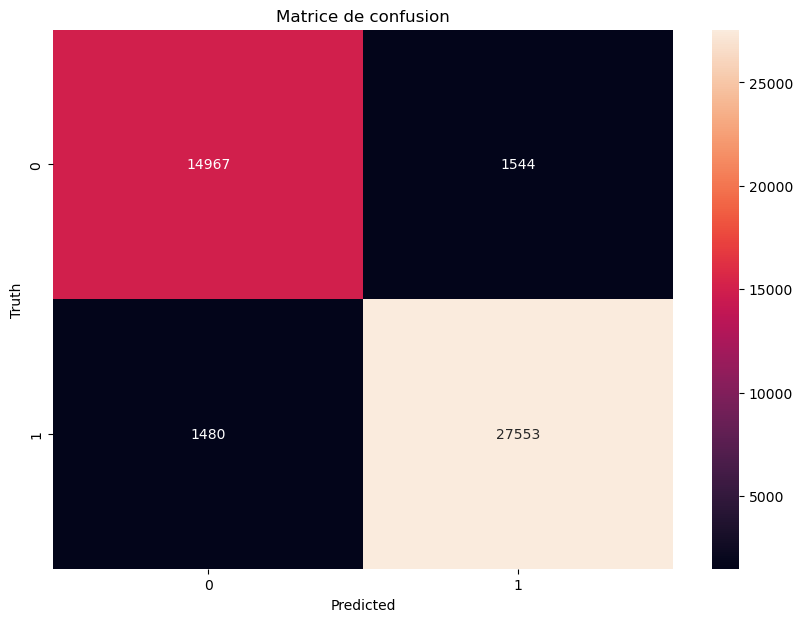

In [34]:
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Matrice de confusion')

In [35]:
print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     16511
           1       0.95      0.95      0.95     29033

    accuracy                           0.93     45544
   macro avg       0.93      0.93      0.93     45544
weighted avg       0.93      0.93      0.93     45544



In [25]:
import colorama
from colorama import Fore, Style
from tensorflow.keras.preprocessing.sequence import pad_sequences

colorama.init(autoreset=True)

test_answers = [
    ('Who is the strongest between Itachi and Jiraiya?', 
    'Itachi is stronger by far and I can prove it.', 
    """It's hard to determine conclusively who is stronger between Itachi and Jiraiya.
     Both have unique strengths and weaknesses. Itachi excels in Sharingan and genjutsu mastery,
      while Jiraiya is a proficient user of ninjutsu and senjutsu. Their relative power depends on various factors, 
      including their respective skills, combat strategies, and physical/mental condition during battle."""
    )
]

def human_or_gpt(n):
    label = "HUMAN" if n[0][0] > 0.5 else 'GPT'
    return Fore.BLUE + label + Style.RESET_ALL

def testsuite(model, tests, tokenizer, max_len):
    for test in tests:
        (qst, human, gpt) = test
        print(f"Question: {qst}")
        
        # Tokenization and padding
        human_seq = tokenizer.texts_to_sequences([human])
        human_pad = pad_sequences(human_seq, maxlen=max_len)
        gpt_seq = tokenizer.texts_to_sequences([gpt])
        gpt_pad = pad_sequences(gpt_seq, maxlen=max_len)
        
        # Prediction
        human_pred = model.predict(human_pad)
        gpt_pred = model.predict(gpt_pad)
        
        print(f"Human Answer: [{human[:25]}] the model thinks it was written by a {human_or_gpt(human_pred)}")
        print(f"GPT Answer: [{gpt[:25]}] the model thinks it was written by a {human_or_gpt(gpt_pred)}")

# Exemple d'utilisation de la fonction avec le tokenizer et max_len appropriés
testsuite(model, test_answers, tokenizer, max_len) 



Question: Who is the strongest between Itachi and Jiraiya?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Human Answer: [Itachi is stronger by far] the model thinks it was written by a HUMAN
GPT Answer: [It's hard to determine co] the model thinks it was written by a GPT
